In [1]:
# import dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
#read in csv
df = pd.read_csv('high_value_add_jack_clean.csv', parse_dates=['Date'], index_col='Date')
df_dv = df.filter(['Date', 'ASP'])
df_dv.head()

,ASP
Date,
2018-11-08,347.76
2016-11-23,216.07
2015-08-21,364.50
2017-09-12,334.08
2018-10-24,556.50


In [3]:
# resample stationary data to monthly due to missing dates from weekends
df_m = df_dv['ASP'].resample('M').mean()
df_m.head()

Date
2014-01-31    263.982436
2014-02-28    300.009434
2014-03-31    329.248950
2014-04-30    299.405828
2014-05-31    319.590464
Freq: M, Name: ASP, dtype: float64

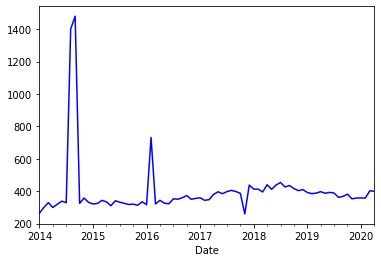

In [4]:
# chart monthly data 
fig, ax = plt.subplots()
df_m.plot(ax=ax, color = 'blue')
plt.show()

In [5]:
#ADF test 1
result = adfuller(df['ASP'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -230.1447410605532
p-value: 0.0
Critical Values:
	1%: -3.430473414610787
	5%: -2.8615945467911765
	10%: -2.5667990334411104


In [6]:
# take the difference from previous time period
df_stationary = df_dv.diff().dropna()
df_stationary.head()

,ASP
Date,
2016-11-23,-131.69
2015-08-21,148.43
2017-09-12,-30.42
2018-10-24,222.42
2015-07-10,-342.10


In [7]:
#ADF test 2
result = adfuller(df_stationary['ASP'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -51.86035933965205
p-value: 0.0
Critical Values:
	1%: -3.430473552185229
	5%: -2.8615946075950642
	10%: -2.566799065805216


In [8]:
# resample the data to monthly due to missing values on weekends
df_m = df_stationary['ASP'].resample('M').mean()

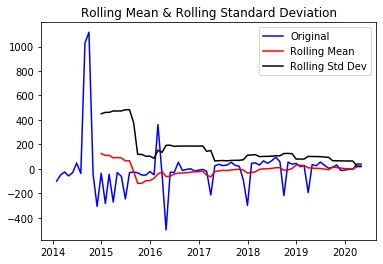

In [9]:
# compare rolling mean and standard devation to stationary data
rolling_mean = df_m.rolling(window = 12).mean()
rolling_std = df_m.rolling(window = 12).std()
plt.plot(df_m, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std Dev')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [30]:
# Train 2017 data
df_train = df_m.loc[:'2017']

# Test 2018 and 2019 data
df_test = df_m.loc['2018':'2020-03-31']

df_train.head()

Date
2014-01-31   -99.593009
2014-02-28   -51.095996
2014-03-31   -25.042672
2014-04-30   -57.541676
2014-05-31   -30.309008
Freq: M, Name: ASP, dtype: float64

(array([735234., 735415., 735599., 735780., 735964., 736146., 736330.,
        736511., 736695.]), <a list of 9 Text xticklabel objects>)

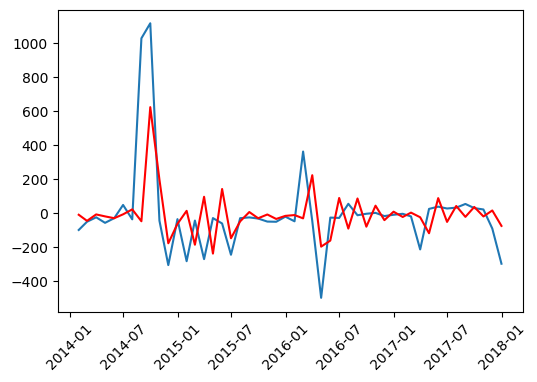

In [16]:
decomposition = seasonal_decompose(df_train) 
model = ARIMA(df_train, order=(1,0,1))
results = model.fit(disp=-1)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(df_m.loc[:'2017'])
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([540, 552, 564, 576]), <a list of 4 Text xticklabel objects>)

<Figure size 600x400 with 0 Axes>

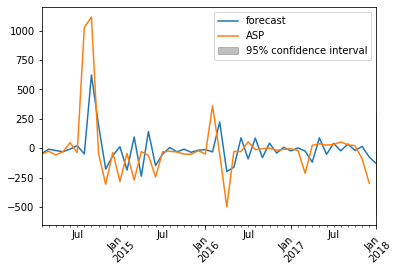

In [17]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_train.iloc[0], index=df_train.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,48)
plt.xticks(rotation=45)

(array([736695., 736785., 736876., 736968., 737060., 737150., 737241.,
        737333., 737425., 737516.]), <a list of 10 Text xticklabel objects>)

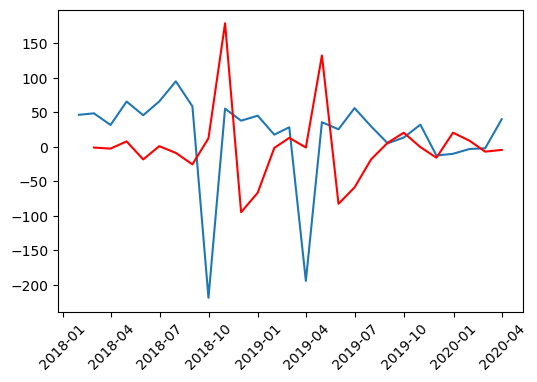

In [19]:
decomposition = seasonal_decompose(df_test) 
model = ARIMA(df_test, order=(2,1,0))
results = model.fit(disp=1)
plt.figure(figsize=(6, 4), dpi=100)
plt.plot(df_m.loc['2018':'2020-03-31'])
plt.plot(results.fittedvalues, color='red')
plt.xticks(rotation=45)

(array([588, 600, 612, 624]), <a list of 4 Text xticklabel objects>)

<Figure size 700x400 with 0 Axes>

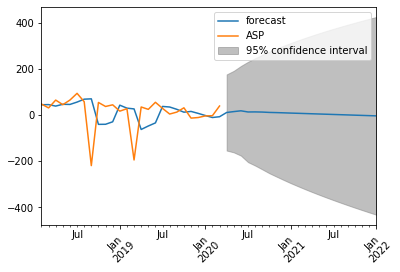

In [20]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_test.iloc[0], index=df_test.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(7, 4), dpi=100)
results.plot_predict(1,48)
plt.xticks(rotation=45)

<Figure size 600x400 with 0 Axes>

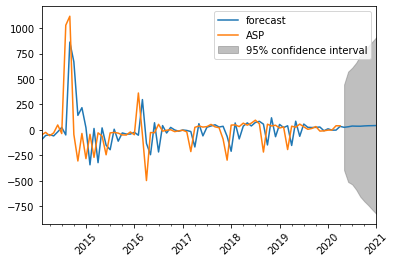

In [29]:
decomposition = seasonal_decompose(df_m) 
model = ARIMA(df_m, order=(2,1,0))
results = model.fit(disp=1)


predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_m.iloc[0], index=df_m.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(6, 4), dpi=100)
results.plot_predict(1,84)
plt.xticks(rotation=45)
plt.savefig('forecast.png')

In [22]:
projected_sales = [540, 552, 564, 576, 588, 600, 612]
analysis_df = pd.DataFrame(projected_sales) 
analysis_df.head()

,0
0,540
1,552
2,564
3,576
4,588


**Results:**

The above data is from the High Value product line, which represents the companies more expensive product line. I used
the ARIMA model to take data beginning in 2014 to forecast future values. Results of the model yielded a confidence 
interval of 87.5% which equates to projected revenue growth of $12M.


Resources used:
https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7